<a href="https://colab.research.google.com/github/sksoumik/machine-learning-projects/blob/master/Intel_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## download data from kaggle

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sadmansoumik","key":"13ae98718981dd5b9e07ae9ed01b5bbe"}'}

In [2]:
!mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d puneet6060/intel-image-classification

 98% 338M/346M [00:02<00:00, 204MB/s]
100% 346M/346M [00:02<00:00, 172MB/s]


In [5]:
%%capture 
!unzip intel-image-classification.zip
!rm intel-image-classification.zip

## import required libraries

In [6]:
# install two required libraries
!pip install torchsummary
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp36-none-any.whl size=16031 sha256=bd12e247c8897eab758dd161baba9d02347911a726bc72b947bafa2d31721ee4
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [7]:
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from sklearn import metrics
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import pandas as pd
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import cv2
import os
import torchvision
import shutil
from torch.autograd import Variable
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.models as models
from torchsummary import summary
from efficientnet_pytorch import EfficientNet
import torch.optim as optim
from tqdm.autonotebook import tqdm

## Dataset loading using torchvision

In [8]:
# parameters 

batch_size = 8
img_size = 150

In [9]:
# data normalization 
def normalization_parameter(dataloader):
    mean = 0.
    std = 0.
    nb_samples = len(dataloader.dataset)
    for data, _ in tqdm(dataloader):
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
    mean /= nb_samples
    std /= nb_samples
    return mean.numpy(),std.numpy()

In [10]:
# transformation for train data 

train_transforms = transforms.Compose(
    [transforms.Resize((img_size, img_size)),
     transforms.ToTensor()])

In [11]:
train_data = torchvision.datasets.ImageFolder(root="/content/seg_train/seg_train", 
                                              transform=train_transforms,
                                              )

In [12]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True) 
mean, std = normalization_parameter(train_loader) 

In [13]:
#image transformations for train and test data

train_transforms = transforms.Compose([
                                        transforms.Resize((img_size,img_size)),
                                        transforms.RandomResizedCrop(size=315, scale=(0.95, 1.0)),
                                        transforms.RandomRotation(degrees=10),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.CenterCrop(size=299),  # Image net standards
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)
                                        ])
test_transforms = transforms.Compose([
                                        transforms.Resize((img_size,img_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)
                                        ])

In [14]:
#inverse normalization for image plot

inv_normalize =  transforms.Normalize(
    mean=-1*np.divide(mean,std),
    std=1/std
)

In [15]:
def data_loader(train_data, test_data=None, valid_size=None, batch_size=32):
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    if (test_data == None and valid_size == None):
        dataloaders = {'train': train_loader}
        return dataloaders
    if (test_data == None and valid_size != None):
        data_len = len(train_data)
        indices = list(range(data_len))
        np.random.shuffle(indices)
        split1 = int(np.floor(valid_size * data_len))
        valid_idx, test_idx = indices[:split1], indices[split1:]
        valid_sampler = SubsetRandomSampler(valid_idx)
        valid_loader = DataLoader(train_data,
                                  batch_size=batch_size,
                                  sampler=valid_sampler)
        dataloaders = {'train': train_loader, 'val': valid_loader}
        return dataloaders
    if (test_data != None and valid_size != None):
        data_len = len(test_data)
        indices = list(range(data_len))
        np.random.shuffle(indices)
        split1 = int(np.floor(valid_size * data_len))
        valid_idx, test_idx = indices[:split1], indices[split1:]
        valid_sampler = SubsetRandomSampler(valid_idx)
        test_sampler = SubsetRandomSampler(test_idx)
        valid_loader = DataLoader(test_data,
                                  batch_size=batch_size,
                                  sampler=valid_sampler)
        test_loader = DataLoader(test_data,
                                 batch_size=batch_size,
                                 sampler=test_sampler)
        dataloaders = {
            'train': train_loader,
            'val': valid_loader,
            'test': test_loader
        }
        return dataloaders

In [16]:
# create data loaders 

train_data = torchvision.datasets.ImageFolder(root="/content/seg_train/seg_train",
                                              transform=train_transforms)

test_data = torchvision.datasets.ImageFolder(root="/content/seg_test/seg_test",
                                             transform=test_transforms)

dataloaders = data_loader(train_data, test_data, 
                          valid_size=0.2, 
                          batch_size=batch_size)

In [17]:
# label names of classes 
classes = train_data.classes
print(classes)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [18]:
#encoder and decoder to convert classes into integer
decoder = {}
for i in range(len(classes)):
    decoder[classes[i]] = i
encoder = {}
for i in range(len(classes)):
    encoder[i] = classes[i]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


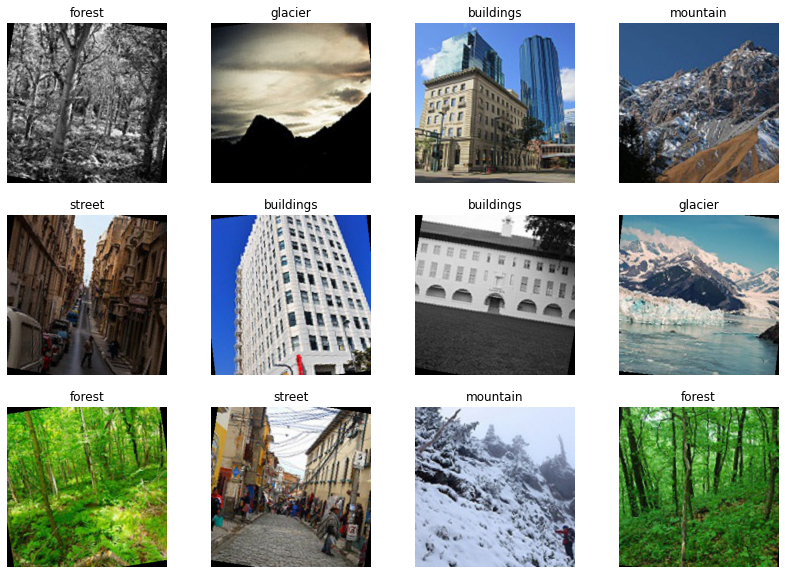

In [19]:
import matplotlib.pyplot as plt
import random
#plotting rondom images from dataset
def class_plot(data , encoder ,inv_normalize = None,n_figures = 12):
    n_row = int(n_figures/4)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=4)
    for ax in axes.flatten():
        a = random.randint(0,len(data))
        (image,label) = data[a]
        print(type(image))
        label = int(label)
        l = encoder[label]
        if(inv_normalize!=None):
            image = inv_normalize(image)
        
        image = image.numpy().transpose(1,2,0)
        im = ax.imshow(image)
        ax.set_title(l)
        ax.axis('off')
    plt.show()
class_plot(train_data,encoder,inv_normalize)

## Define Model

In [20]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.resnet = EfficientNet.from_pretrained('efficientnet-b0')
        self.l1 = nn.Linear(1000, 256)
        self.dropout = nn.Dropout(0.75)
        self.l2 = nn.Linear(256, 6)
        self.relu = nn.ReLU() 
    
    def forward(self, input): 
        x = self.resnet(input)
        x = x.view(x.size(0), -1) 
        x = self.dropout(self.relu(self.l1(x)))
        x = self.l2(x) 
        return x 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier = Classifier().to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0


In [21]:
# Loss -> Negative log likelihood loss if output layer logsoftmax else for linear layer we use crossentropy loss.
criterion = nn.CrossEntropyLoss()

## Early Stopping

In [22]:
import numpy as np
import torch
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

## Learning rate finder

In [23]:
!pip install torch-lr-finder

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.89E-03


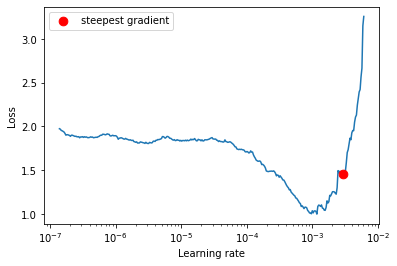

(<matplotlib.axes._subplots.AxesSubplot at 0x7fbc33533630>,
 0.0028901597179095085)

In [24]:
from torch_lr_finder import LRFinder

optimizer_ft = optim.Adam(classifier.parameters(), lr=0.0000001)
lr_finder = LRFinder(classifier, optimizer_ft, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=1, num_iter=500)
lr_finder.reset()
lr_finder.plot()

## Train

In [25]:
def train(model,
          dataloaders,
          criterion,
          num_epochs=10,
          lr=2.89E-03,
          batch_size=8,
          patience=None):
    since = time.time()
    model.to(device)
    best_acc = 0.0
    i = 0
    phase1 = dataloaders.keys()
    losses = list()
    acc = list()
    if (patience != None):
        earlystop = EarlyStopping(patience=patience, verbose=True)
    for epoch in range(num_epochs):
        print('Epoch:', epoch)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        lr = lr * 0.8
        if (epoch % 10 == 0):
            lr = 0.0001

        for phase in phase1:
            if phase == ' train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            total = 0
            j = 0
            for batch_idx, (data, target) in enumerate(dataloaders[phase]):
                data, target = Variable(data), Variable(target)
                data = data.type(torch.cuda.FloatTensor)
                target = target.type(torch.cuda.LongTensor)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                _, preds = torch.max(output, 1)
                running_corrects = running_corrects + torch.sum(
                    preds == target.data)
                running_loss += loss.item() * data.size(0)
                j = j + 1
                if (phase == 'train'):
                    loss.backward()
                    optimizer.step()

                if batch_idx % 300 == 0:
                    print(
                        '{} Epoch: {}  [{}/{} ({:.0f}%)]\tLoss: {:.6f} \tAcc: {:.6f}'
                        .format(phase, epoch, batch_idx * len(data),
                                len(dataloaders[phase].dataset),
                                100. * batch_idx / len(dataloaders[phase]),
                                running_loss / (j * batch_size),
                                running_corrects.double() / (j * batch_size)))
            epoch_acc = running_corrects.double() / (len(dataloaders[phase]) *
                                                     batch_size)
            epoch_loss = running_loss / (len(dataloaders[phase]) * batch_size)
            if (phase == 'val'):
                earlystop(epoch_loss, model)

            if (phase == 'train'):
                losses.append(epoch_loss)
                acc.append(epoch_acc)
            print(earlystop.early_stop)
        if (earlystop.early_stop):
            print("Early stopping")
            model.load_state_dict(torch.load('./checkpoint.pt'))
            break
        print('{} Accuracy: '.format(phase), epoch_acc.item())
    return losses, acc

## Test

In [26]:
def test(dataloader):
    running_corrects = 0
    running_loss = 0
    pred = []
    true = []
    pred_wrong = []
    true_wrong = []
    image = []
    sm = nn.Softmax(dim=1)
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = Variable(data), Variable(target)
        data = data.type(torch.cuda.FloatTensor)
        target = target.type(torch.cuda.LongTensor)
        classifier.eval()
        output = classifier(data)
        loss = criterion(output, target)
        output = sm(output)
        _, preds = torch.max(output, 1)
        running_corrects = running_corrects + torch.sum(preds == target.data)
        running_loss += loss.item() * data.size(0)
        preds = preds.cpu().numpy()
        target = target.cpu().numpy()
        preds = np.reshape(preds, (len(preds), 1))
        target = np.reshape(target, (len(preds), 1))
        data = data.cpu().numpy()

        for i in range(len(preds)):
            pred.append(preds[i])
            true.append(target[i])
            if (preds[i] != target[i]):
                pred_wrong.append(preds[i])
                true_wrong.append(target[i])
                image.append(data[i])

    epoch_acc = running_corrects.double() / (len(dataloader) * batch_size)
    epoch_loss = running_loss / (len(dataloader) * batch_size)
    print(epoch_acc, epoch_loss)
    return true, pred, image, true_wrong, pred_wrong

In [27]:
def error_plot(loss):
    plt.figure(figsize=(10, 5))
    plt.plot(loss)
    plt.title("Training loss plot")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.show()


def acc_plot(acc):
    plt.figure(figsize=(10, 5))
    plt.plot(acc)
    plt.title("Training accuracy plot")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.show()


# To plot the wrong predictions given by model
def wrong_plot(n_figures, true, ima, pred, encoder, inv_normalize):
    print('Classes in order Actual and Predicted')
    n_row = int(n_figures / 3)
    fig, axes = plt.subplots(figsize=(14, 10), nrows=n_row, ncols=3)
    for ax in axes.flatten():
        a = random.randint(0, len(true) - 1)

        image, correct, wrong = ima[a], true[a], pred[a]
        image = torch.from_numpy(image)
        correct = int(correct)
        c = encoder[correct]
        wrong = int(wrong)
        w = encoder[wrong]
        f = 'A:' + c + ',' + 'P:' + w
        if inv_normalize != None:
            image = inv_normalize(image)
        image = image.numpy().transpose(1, 2, 0)
        im = ax.imshow(image)
        ax.set_title(f)
        ax.axis('off')
    plt.show()


def plot_confusion_matrix(y_true,
                          y_pred,
                          classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel='True label',
        xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(),
             rotation=45,
             ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j,
                    i,
                    format(cm[i, j], fmt),
                    ha="center",
                    va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


def performance_matrix(true, pred):
    precision = metrics.precision_score(true, pred, average='macro')
    recall = metrics.recall_score(true, pred, average='macro')
    accuracy = metrics.accuracy_score(true, pred)
    f1_score = metrics.f1_score(true, pred, average='macro')
    print('\n\nPrecision: {} Recall: {}, Accuracy: {}: ,f1_score: {}'.format(
        precision * 100, recall * 100, accuracy * 100, f1_score * 100))

In [28]:
def train_model(model,
                dataloaders,
                criterion,
                num_epochs=10,
                lr=0.0001,
                batch_size=8,
                patience=None,
                classes=None):
    dataloader_train = {}
    losses = list()
    accuracy = list()
    key = dataloaders.keys()
    for phase in key:
        if (phase == 'test'):
            perform_test = True
        else:
            dataloader_train.update([(phase, dataloaders[phase])])
    losses, accuracy = train(model, dataloader_train, criterion, num_epochs,
                             lr, batch_size, patience)
    error_plot(losses)
    acc_plot(accuracy)
    if (perform_test == True):
        true, pred, image, true_wrong, pred_wrong = test(dataloaders['test'])
        wrong_plot(12, true_wrong, image, pred_wrong, encoder, inv_normalize)
        performance_matrix(true, pred)
        if (classes != None):
            plot_confusion_matrix(
                true,
                pred,
                classes=classes,
                title='Confusion matrix, without normalization')

Epoch: 0
train Epoch: 0  [0/14034 (0%)]	Loss: 1.890662 	Acc: 0.125000
train Epoch: 0  [2400/14034 (17%)]	Loss: 0.395293 	Acc: 0.848837
train Epoch: 0  [4800/14034 (34%)]	Loss: 0.339197 	Acc: 0.874168
train Epoch: 0  [7200/14034 (51%)]	Loss: 0.303737 	Acc: 0.889290
train Epoch: 0  [9600/14034 (68%)]	Loss: 0.286723 	Acc: 0.897065
train Epoch: 0  [12000/14034 (85%)]	Loss: 0.274946 	Acc: 0.901233
False
val Epoch: 0  [0/3000 (0%)]	Loss: 0.123227 	Acc: 0.875000
Validation loss decreased (inf --> 0.273706).  Saving model ...
False
val Accuracy:  0.9
Epoch: 1
train Epoch: 1  [0/14034 (0%)]	Loss: 0.038656 	Acc: 1.000000
train Epoch: 1  [2400/14034 (17%)]	Loss: 0.180074 	Acc: 0.941860
train Epoch: 1  [4800/14034 (34%)]	Loss: 0.177171 	Acc: 0.940724
train Epoch: 1  [7200/14034 (51%)]	Loss: 0.181135 	Acc: 0.939095
train Epoch: 1  [9600/14034 (68%)]	Loss: 0.186652 	Acc: 0.937344
train Epoch: 1  [12000/14034 (85%)]	Loss: 0.184181 	Acc: 0.937791
False
val Epoch: 1  [0/3000 (0%)]	Loss: 0.127191 	Acc: 

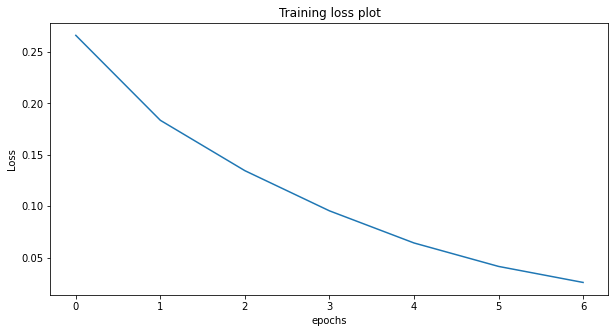

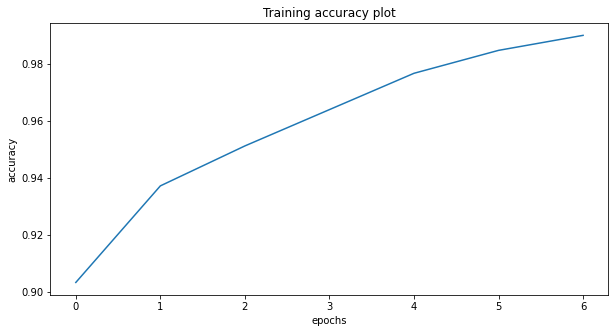

tensor(0.9083, device='cuda:0', dtype=torch.float64) 0.2548253457977747
Classes in order Actual and Predicted


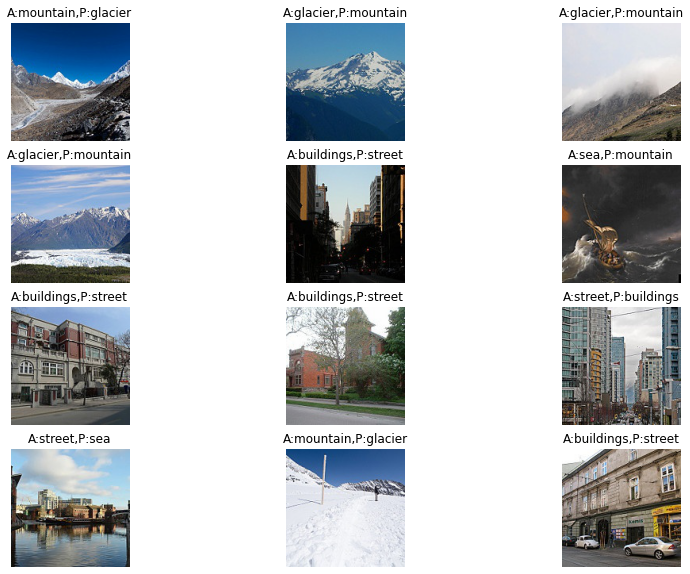

Precision: 91.47906403790356 Recall: 90.89757594741582, Accuracy: 90.83333333333333: ,f1_score: 90.91420264805058
Confusion matrix, without normalization
[[286   0   0   3   1  45]
 [  1 387   5   0   0   1]
 [  0   0 345  89  10   1]
 [  1   3  20 365  10   0]
 [  2   3   7   8 398   1]
 [  5   0   1   2   1 399]]


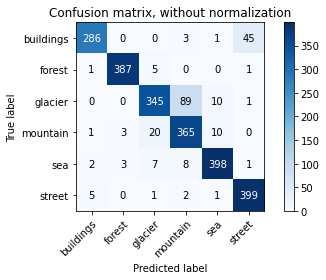

In [29]:
train_model(classifier,dataloaders,criterion,10, patience = 3 , batch_size = batch_size , classes = classes)

## Predict

In [30]:
#Predict
from PIL import Image
import numpy as np
import cv2


def predict(model,
            image,
            device,
            encoder,
            transforms=None,
            inv_normalize=None):
    #model = torch.load('./model.h5')
    model.eval()
    if (isinstance(image, np.ndarray)):
        image = Image.fromarray(image)
    if (transforms != None):
        image = transforms(image)
    data = image.expand(1, -1, -1, -1)
    data = data.type(torch.FloatTensor).to(device)
    sm = nn.Softmax(dim=1)
    output = model(data)
    output = sm(output)
    _, preds = torch.max(output, 1)
    img_plot(image, inv_normalize)
    prediction_bar(output, encoder)
    return preds


def prediction_bar(output, encoder):
    output = output.cpu().detach().numpy()
    a = output.argsort()
    a = a[0]

    size = len(a)
    if (size > 5):
        a = np.flip(a[-5:])
    else:
        a = np.flip(a[-1 * size:])
    prediction = list()
    clas = list()
    for i in a:
        prediction.append(float(output[:, i] * 100))
        clas.append(str(i))
    for i in a:
        print('Class: {} , confidence: {}'.format(encoder[int(i)],
                                                  float(output[:, i] * 100)))
    plt.bar(clas, prediction)
    plt.title("Confidence score bar graph")
    plt.xlabel("Confidence score")
    plt.ylabel("Class number")


def img_plot(image, inv_normalize=None):
    if (inv_normalize != None):
        image = inv_normalize(image)
    image = image.cpu().numpy().transpose(1, 2, 0)
    plt.imshow(image)
    plt.show()

## image to predict

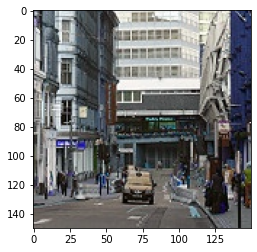

Class: street , confidence: 82.04289245605469
Class: buildings , confidence: 16.360742568969727
Class: glacier , confidence: 0.7568790912628174
Class: forest , confidence: 0.45759254693984985
Class: sea , confidence: 0.22643131017684937


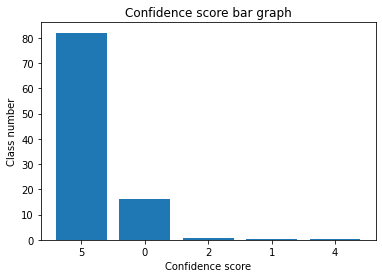

In [31]:
# path to image (that would be predicted) 
image = cv2.imread('/content/seg_pred/seg_pred/10012.jpg')
pred = predict(classifier,image,device,encoder,test_transforms,inv_normalize)

## heatmap

In [51]:
import cv2
import matplotlib.pyplot as plt

sm = nn.Softmax()
test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


def im_convert(tensor):
    """ Display a tensor as an image. """
    image = tensor.to("cpu").clone().detach()
    image = image.squeeze()
    image = inv_normalize(image)
    image = image.numpy()
    image = image.transpose(1, 2, 0)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.clip(0, 1)
    return image


def preprocess(path):
    img = cv2.imread(path)
    img = test_transforms(img)
    img = img.unsqueeze(0)
    return img


def cam(model, path):
    img = preprocess(path)
    fmap, logits = model(img.to('cuda'))
    params = list(model.parameters())
    weight_softmax = model.linear.weight.detach().cpu().numpy()
    logits = sm(logits)
    idx = np.argmax(logits.detach().cpu().numpy())
    bz, nc, h, w = fmap.shape
    out = np.dot(fmap.detach().cpu().numpy().reshape((nc, h * w)).T,
                 weight_softmax[idx, :].T)
    cam = out.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    cam_img = np.uint8(255 * cam_img)
    out = cv2.resize(cam_img, (img_size, img_size))
    heatmap = cv2.applyColorMap(out, cv2.COLORMAP_JET)
    img = im_convert(img)
    result = heatmap * 0.5 + img * 0.8 * 255
    cv2.imwrite('/content/1.png', result)
    result1 = heatmap * 0.5 / 255 + img * 0.8
    r, g, b = cv2.split(result1)
    result1 = cv2.merge((b, g, r))
    plt.imshow(result1)
    plt.show()
